## An End to End Machine Learning Project!

In this chapter we are going to walk through a typical Machine Learning project from end to end.

### Get the Data

First thing to do is get the data. If the following cell doesn't run, consult the _README_. The dataset we are using is a collection of statistics on the first six generations of Pokémon! It can be found [here.](https://www.kaggle.com/abcsds/pokemon) You should put it here: `datasets/pokemon/pokemon.csv`.


In [1]:
import sys
import os
import pandas as pd
import numpy as np

PROJECT_ROOT = os.path.split(os.getcwd())[0]
sys.path.append(PROJECT_ROOT)

from datasets import load_pokemon_data

pokemon = load_pokemon_data()
pokemon.tail()


,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True
799,721,Volcanion,Fire,Water,600,80,110,120,130,90,70,6,True


### Visualize and Explore

Great! Now, the dataset has been loaded as a Pandas DataFrame, we can take a look at some Pokémon! It is a good idea when starting a Machine Learning project to get an initial feel for the data. Pandas provides us a few methods to look at the dataset as a whole.

In [2]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
#             800 non-null int64
Name          800 non-null object
Type 1        800 non-null object
Type 2        414 non-null object
Total         800 non-null int64
HP            800 non-null int64
Attack        800 non-null int64
Defense       800 non-null int64
Sp. Atk       800 non-null int64
Sp. Def       800 non-null int64
Speed         800 non-null int64
Generation    800 non-null int64
Legendary     800 non-null bool
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


Running `pokemon.info` we can see there are 13 columns, and 800 rows. Each column's datatype is also displayed. Here there are three datatypes. `Int64` a (signed) integer, `bool` a _Boolean_ true or false value and `object` which could contain any Python object, but we know is some text.

Some pandas methods only work on numerics so before we continue, lets convert the `bool` type to a numeric by mapping true to 1 and false to 0. 

In [3]:
pokemon["Legendary"] = pokemon['Legendary'].astype(np.int64)

In [4]:
pokemon.describe()

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375,0.08125
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129,0.27339
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000,0.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000,0.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000,0.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000,0.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000,1.00000


One such method is `pokemon.describe()` which gives some statistical measures of the values of each numeric column. This can give us some quick ideas about our data, for example the stats _Attack_, _Defense_, _Sp. Attack_, _Sp. Defense_ and _Speed_ are all similarly distributed, with similar means and standard deviations. The _Total_ stat is, however, greater and has a narrower distribution. Knowing that the _Total_ column is in fact the sum of the other stat columns, we could intuit that Pokémon with higher _Attack_ may how lower values for the other stats.

Now let's see what these distributions look like.

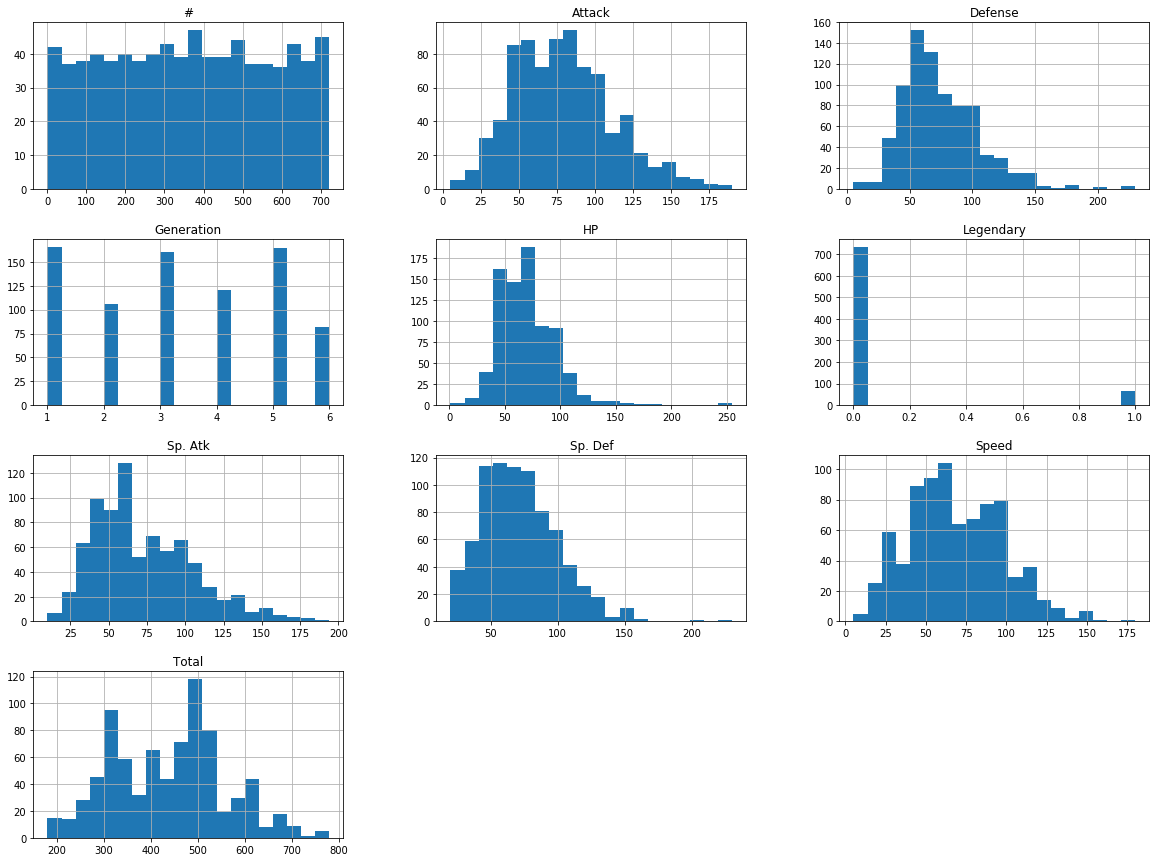

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

pokemon.hist(bins=20, figsize=(20,15))
plt.show()

## Wait! It's dangerous to go alone!

### Test / Train Split

Before we go any further we must create a test set, hide it away and not look at it until we're good and ready. It's important that we keep this test set for testing only to ensure that any changes we make to our model will generalize well to new data. The test set must be _new_ data. 

So how do we generate a test set? Generally we will pick some fraction of the data at random. Often 20% is set aside as test while the other 80% remains as the _train_ set. Lets try picking rows at random.



In [6]:
def split_train_test(dataset, ratio):
    shuffled_indices = np.random.permutation(len(dataset))
    test_set_size = int(len(dataset) * ratio)
    return (
        dataset.iloc[shuffled_indices[test_set_size:]],
        dataset.iloc[shuffled_indices[:test_set_size]]
    )

train_set, test_set = split_train_test(pokemon, 0.2)

test_set.shape

(160, 13)

Great! This works and is largely what the _out of the box_ method *sklearn.model_selection.train_test_split* is doing but it has one problem: running this twice over the same dataset will produce different test sets. This defeats the purpose of our test set, over multiple runs the model may _see_ all of the data points! Okay, so what's the solution? Instead of taking the rows at random, lets instead use an identifier, hash that and take the first 20%

What to use as the identifier? Ideally there is some unique identifier in you dataset. If not, we may have to add one from a combination of other columns, or instead a totally artificial one. Its important though that the identifier remains the same if the data is ever updated. For our dataset there is one identifier calling out to us!

In [7]:
from zlib import crc32 #hashing function

def test_set_check(id_string, ratio):
    return crc32(bytes(id_string, 'utf-8')) & 0xffffffff < ratio * 2**32

def split_train_test_id(dataset, ratio, id_column):
    is_test_set = dataset[id_column].apply(lambda id_: test_set_check(id_, ratio))
    return dataset[~is_test_set], dataset[is_test_set]

train_set, test_set = split_train_test_id(pokemon, 0.2, 'Name')

test_set.shape

(168, 13)

Okay, so test set created, lets forget that it exists. 

In [8]:
pokemon = train_set.copy()

pokemon.shape

(632, 13)

Suppose we find a new pokemon. We want to predict it's _Sp. Def_ from its other stats.

Let's take another look at the data. Plots are a great way to do that.

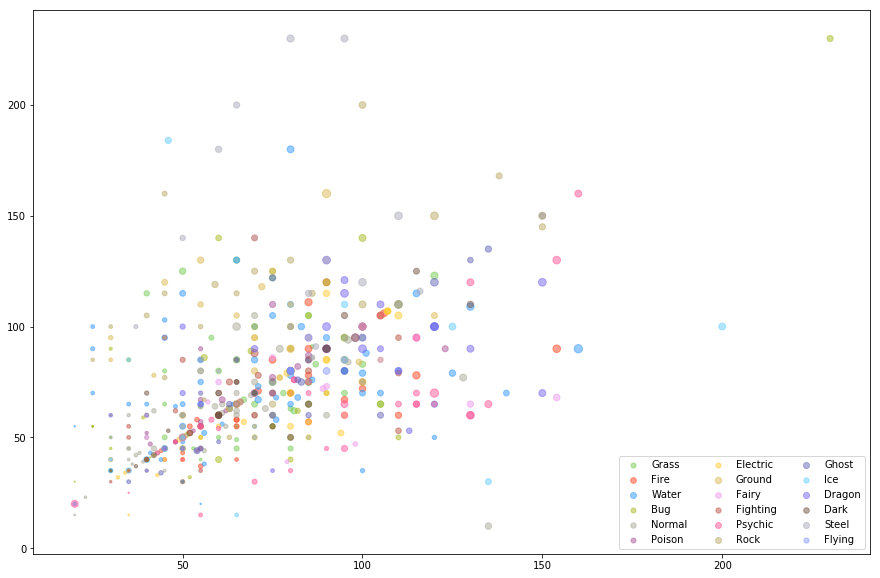

In [9]:
#this is purely aesthetic and can be ignored.
def type_color(type_):
    try:
        return {'Bug': '#aabb22','Dark': '#775544','Dragon': '#7766ee','Electric': '#ffcc33','Fairy': '#ee99ee','Fighting': '#bb5544','Fire': '#ff4422','Flying': '#8899ff','Ghost': '#6666bb','Grass': '#77cc55','Ground': '#ddbb55','Ice': '#66ccff','Normal': '#aaaa99','Poison': '#aa5599','Psychic': '#ff5599','Rock': '#bbaa66','Steel': '#aaaabb','Water': '#3399ff'}[type_]
    except KeyError:
        return '#000000'

total_max = pokemon['Total'].max()
total_min = pokemon['Total'].min()

def total_to_size(total, min_r, max_r):
    return (max_r - min_r) * (total - total_min) / (total_max - total_min)

fig, ax = plt.subplots(figsize=(15,10))
artists = []
for type_ in pokemon['Type 1'].unique():
    pokemons = pokemon[pokemon['Type 1'] == type_]
    color = type_color(type_)
    ax.scatter(
        x=pokemons['Sp. Def'],
        y=pokemons['Defense'],
        alpha=0.5,
        s=pokemons['Total'].apply(lambda t: total_to_size(t, 10, 80)),
#         figsize=(15,10),
        c=color,
        label=type_
    )
ax.legend(loc=4, ncol=3)
plt.show()

Interesting, there doesn't seem to be a strong correlation between _Defense_ and _Sp. Def_ but we can see that there alot of pokemon which share a _Defense_ and _Sp. Def_ stat!

Also, the pokemons primary type (the color of the dots) appears to affect which side of the equality line the pokemon falls. E.g. Fairy types (pink) have greater _Sp. Def_ while Normal (grey) types have greater _Defense_.

Are there _any_ simple correlations in our dataset? One measure of this is the _Standard (Or Pearson) Correlation Coeffecient_. Pandas provides a neat way to calculate this.

High correlation is denoted by an absolute value of this coeffecient close to one, while low correlation is close to zero.


In [10]:
corr_matrix = pokemon.corr()
corr_matrix['Sp. Def'].sort_values(ascending=False)


Sp. Def       1.000000
Total         0.716735
Defense       0.508734
Sp. Atk       0.504765
HP            0.365736
Legendary     0.355989
Speed         0.269776
Attack        0.247109
#             0.079928
Generation    0.023874
Name: Sp. Def, dtype: float64

Cool! There's something there, but there are no obvious candidates. What other options do we have? Firstly there are the non-numeric attributes, like the Types that we saw earlier. It could also be that some combination of attributes is a better predictor. 

What do we know about different pokemon. Well, some are stronger than others, perhaps instead of an absolute Defense stat, we need to look at the stats as a ratio of their total.

Let's add these columns, and rerun our corr_matrix.


In [11]:
pokemon['Rel. Defense'] = pokemon['Defense'] / pokemon['Total']
pokemon['Rel. Attack']  = pokemon['Attack']  / pokemon['Total']

corr_matrix_two = pokemon.corr()
corr_matrix_two['Sp. Def'].sort_values(ascending=False)


Sp. Def         1.000000
Total           0.716735
Defense         0.508734
Sp. Atk         0.504765
HP              0.365736
Legendary       0.355989
Speed           0.269776
Attack          0.247109
#               0.079928
Rel. Defense    0.036787
Generation      0.023874
Rel. Attack    -0.325606
Name: Sp. Def, dtype: float64

Well! That wasn't much better, but we can continue. This stage is really just about exploring and trying out ideas.

### Preparing and Cleaning!


Before we let some algorithms loose on our data, we need to perform some preparation steps. Most algorithms perform better with the data in some format and without any missing or non-numerical values. 

Let's transform our _Type_ categories to be more computer readable. Pandas provides us an easy way to do this with `factorize` but first we need to handle the empty values in _Type 2_.

Sklearn gives us a handy function to do this in `sklearn.impute.SimpleImputer`, where _impute_ means here "To replace missing data with substituted values.", apparently.


In [22]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(
    missing_values = np.nan,
    fill_value='Single',
    strategy="constant"
)
imputer.fit(pokemon)
poke_columns = pokemon.columns
pokemon = pd.DataFrame(imputer.transform(pokemon))
pokemon.columns = poke_columns

pokemon.head()

,#,Name,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,2 - Steel,2 - Ice,2 - Rock,2 - Dark,2 - Water,2 - Electric,2 - Fire,2 - Ghost,2 - Bug,2 - Normal
0,1,Bulbasaur,318,45,49,49,65,65,45,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Ivysaur,405,60,62,63,80,80,60,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Venusaur,525,80,82,83,100,100,80,1,...,0,0,0,0,0,0,0,0,0,0
3,3,VenusaurMega Venusaur,625,80,100,123,122,120,80,1,...,0,0,0,0,0,0,0,0,0,0
4,4,Charmander,309,39,52,43,60,50,65,1,...,0,0,0,0,0,0,0,0,0,0


Ok great, we can replace values with this imputer, but why bother? Well with scikit-learns transformers we can use a pipeline to transform all of our data at once. This will be useful to apply the same transformations to our test set.

For now, let's transform our Type columns into an array of _one hot_ encoded columns. We do this because the numerical values returned from `factorize` are independent. They are data labels, not a scale.


In [23]:
from sklearn.preprocessing import OneHotEncoder

type_one_encoded, type_ones = pokemon['Type 1'].factorize()
type_two_encoded, type_twos = pokemon['Type 2'].factorize()

encoder  = OneHotEncoder(categories="auto")
type_one_cat = encoder.fit_transform(type_one_encoded.reshape(-1, 1))
type_two_cat = encoder.fit_transform(type_two_encoded.reshape(-1, 1))

type_ones

KeyError: 'Type 1'

In [20]:
type_one_matrix  = pd.DataFrame(type_one_cat.todense())
type_one_matrix.columns = ['1 - {}'.format(t) for t in type_ones]

type_two_matrix  = pd.DataFrame(type_two_cat.todense())
type_two_matrix.columns = ['2 - {}'.format(t) for t in type_twos]

pokemon = pokemon.join(type_one_matrix).join(type_two_matrix)

pokemon = pokemon.drop('Type 1', axis=1)
pokemon = pokemon.drop('Type 2', axis=1)


ValueError: columns overlap but no suffix specified: Index(['1 - Grass', '1 - Fire', '1 - Water', '1 - Bug', '1 - Normal',
       '1 - Poison', '1 - Electric', '1 - Ground', '1 - Fairy', '1 - Fighting',
       '1 - Psychic', '1 - Rock', '1 - Ghost', '1 - Ice', '1 - Dragon',
       '1 - Dark', '1 - Steel', '1 - Flying'],
      dtype='object')

### Time to Train some Models!

Okay so now we have our data prepared, it's time to look at training some ML models. First off, let's try out a simple one.

In [24]:
from sklearn.linear_model import LinearRegression

labels = pokemon['Sp. Def']
data = pokemon.drop('Sp. Def', axis=1)
data = data.drop('Total', axis=1)
data = data.drop('Name', axis=1)
data = data.drop('#', axis=1)

lin_reg = LinearRegression()
lin_reg.fit(data, labels)

data.head()

#I got a warning running this method from scipy about an external
#dependency. It seems fine however.


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:503: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


,HP,Attack,Defense,Sp. Atk,Speed,Generation,Legendary,Rel. Defense,Rel. Attack,1 - Grass,...,2 - Steel,2 - Ice,2 - Rock,2 - Dark,2 - Water,2 - Electric,2 - Fire,2 - Ghost,2 - Bug,2 - Normal
0,45,49,49,65,45,1,0,0.154088,0.154088,1,...,0,0,0,0,0,0,0,0,0,0
1,60,62,63,80,60,1,0,0.155556,0.153086,1,...,0,0,0,0,0,0,0,0,0,0
2,80,82,83,100,80,1,0,0.158095,0.15619,1,...,0,0,0,0,0,0,0,0,0,0
3,80,100,123,122,80,1,0,0.1968,0.16,1,...,0,0,0,0,0,0,0,0,0,0
4,39,52,43,60,65,1,0,0.139159,0.168285,0,...,0,0,0,0,0,0,0,0,0,0


Ok cool! That seemed fairly painless, so has it worked? Let's try out our new model on a few samples

In [25]:
for i in range(35, 40):
    print("{}\t{:.2f}\t{}".format(
        pokemon.iloc[i]['Name'],
        lin_reg.predict([data.iloc[i]])[0],
        labels.iloc[i]
    ))


Ninetales	83.87	100
Wigglytuff	65.18	50
Zubat	45.48	40
Golbat	71.45	75
Oddish	65.02	65


Great! Not bad at all, the worst here is out by about 13% but we can make a prediction, and it won't be too far out. So how can we tell how the model is performing on the training set as a whole?

We can calculate the Root Mean Square Error (RMSE). The is the sqrt of the squares of the errors for each data point.


In [26]:
from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(data)
mse = mean_squared_error(predictions, labels)

rmse = np.sqrt(mse)
mean = pokemon['Sp. Def'].mean()

print("{:.2f}\t{:.2f}".format(rmse, mean))


15.02	71.72


Okay so not great in general. So what's going on? It seems the model does not have sufficient freedom to match the data. Let's try a more complicated model.


In [27]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor()
random_forest.fit(data, labels)


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [28]:
for i in range(35, 40):
    print("{}\t{:.2f}\t{}".format(
        pokemon.iloc[i]['Name'],
        random_forest.predict([data.iloc[i]])[0],
        labels.iloc[i]
    ))

Ninetales	94.60	100
Wigglytuff	51.50	50
Zubat	37.00	40
Golbat	74.90	75
Oddish	64.50	65


Ok cool, we can see that some of these predictions are pretty close. Let's compare again using RMSE

In [29]:
predictions = random_forest.predict(data)
mse = mean_squared_error(predictions, labels)

rmse = np.sqrt(mse)
mean = pokemon['Sp. Def'].mean()

print("{:.2f}\t{:.2f}".format(rmse, mean))


7.97	71.72


Well this is better. Something like a 10% error. This is pretty good for a first go. The thing to do now would be to try a range of different models, and select one that we find acceptable.